In [104]:
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX


warnings.filterwarnings('ignore')

In [105]:
data = sm.datasets.co2.load_pandas()
y = data.data
y

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
...,...
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3


In [106]:

y.index.sort_values()

y = y['co2'].resample('MS').mean()

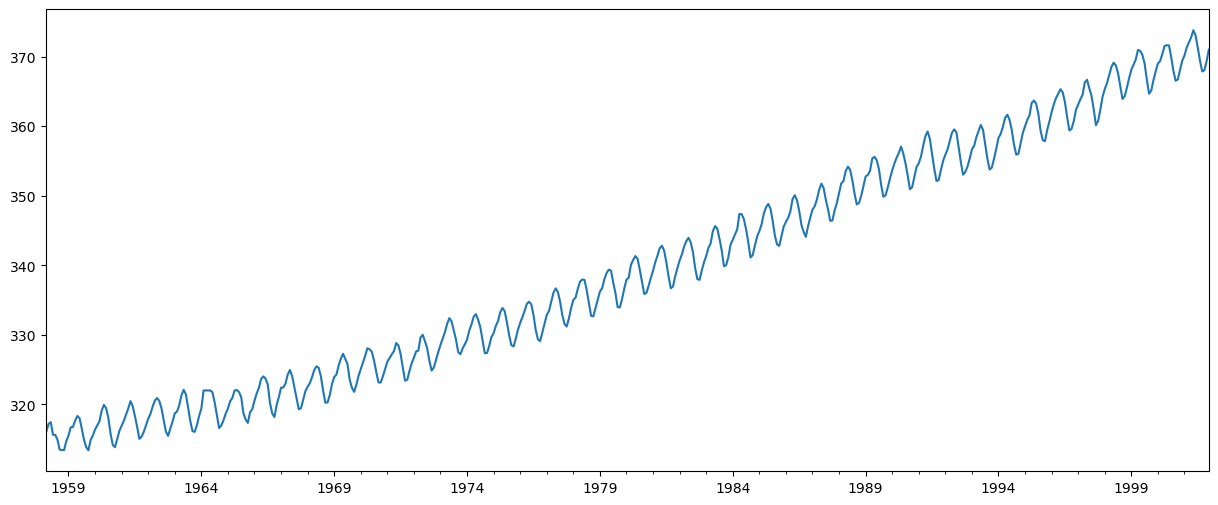

In [107]:
y = y.fillna(y.bfill())
y.head()

y.plot(figsize=(15, 6))
plt.show()

In [108]:
# Train set.
train = y[:'1997-12-01']
len(train)  # 478 months

# Test set.
test = y['1998-01-01':]
len(test)  # 48 moths

48

# Dickey-Fuller Test

We will use Augmented Dickey-Fuller test to test our null hypothesis that our series is not stationary. If we get a significant p value, we will reject our null hypothesis and establish that our series is stationary. On the contrary, if we fail to reject our null hypothesis, we will difference the series and run the test again.

In [109]:
def is_stationary(y):

    # "HO: Non-stationary"
    # "H1: Stationary"

    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        print(F"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        print(F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")


is_stationary(y)

Result: Non-Stationary (H0: non-stationary, p-value: 0.999)


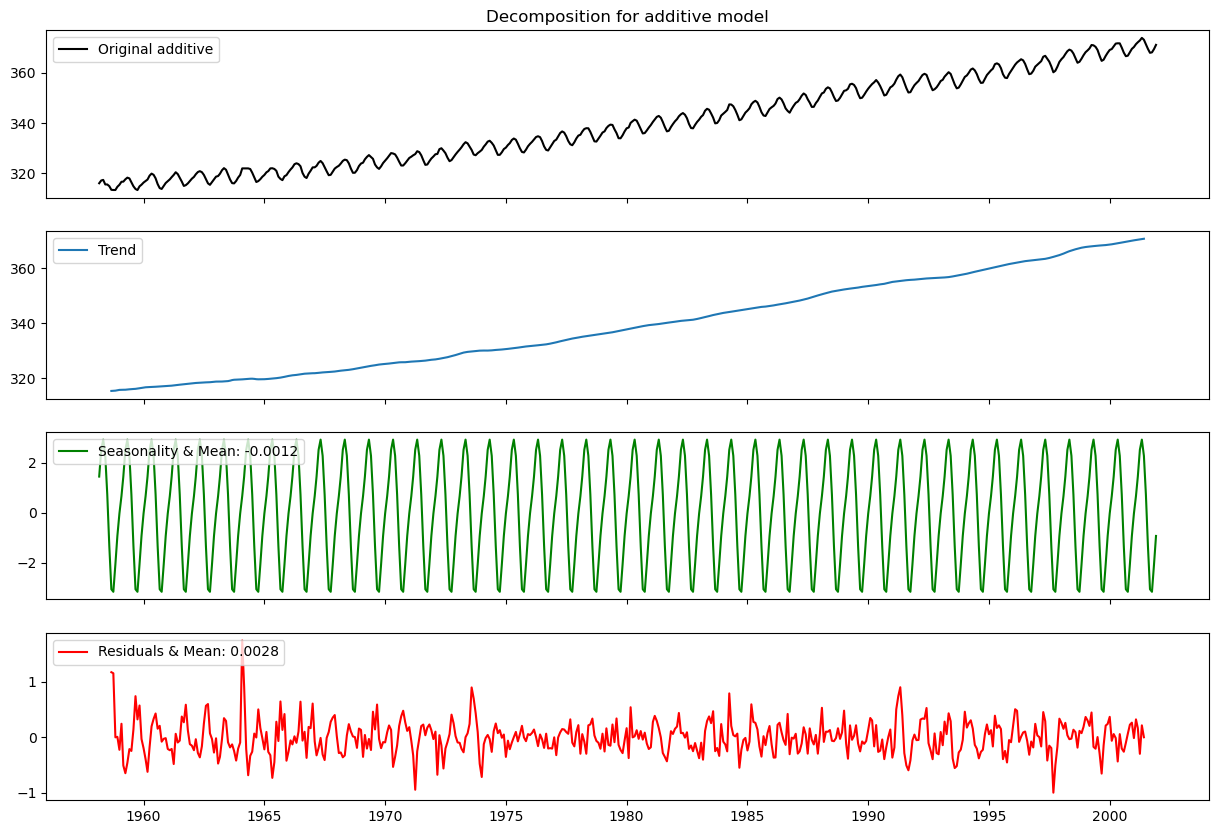

Result: Non-Stationary (H0: non-stationary, p-value: 0.999)


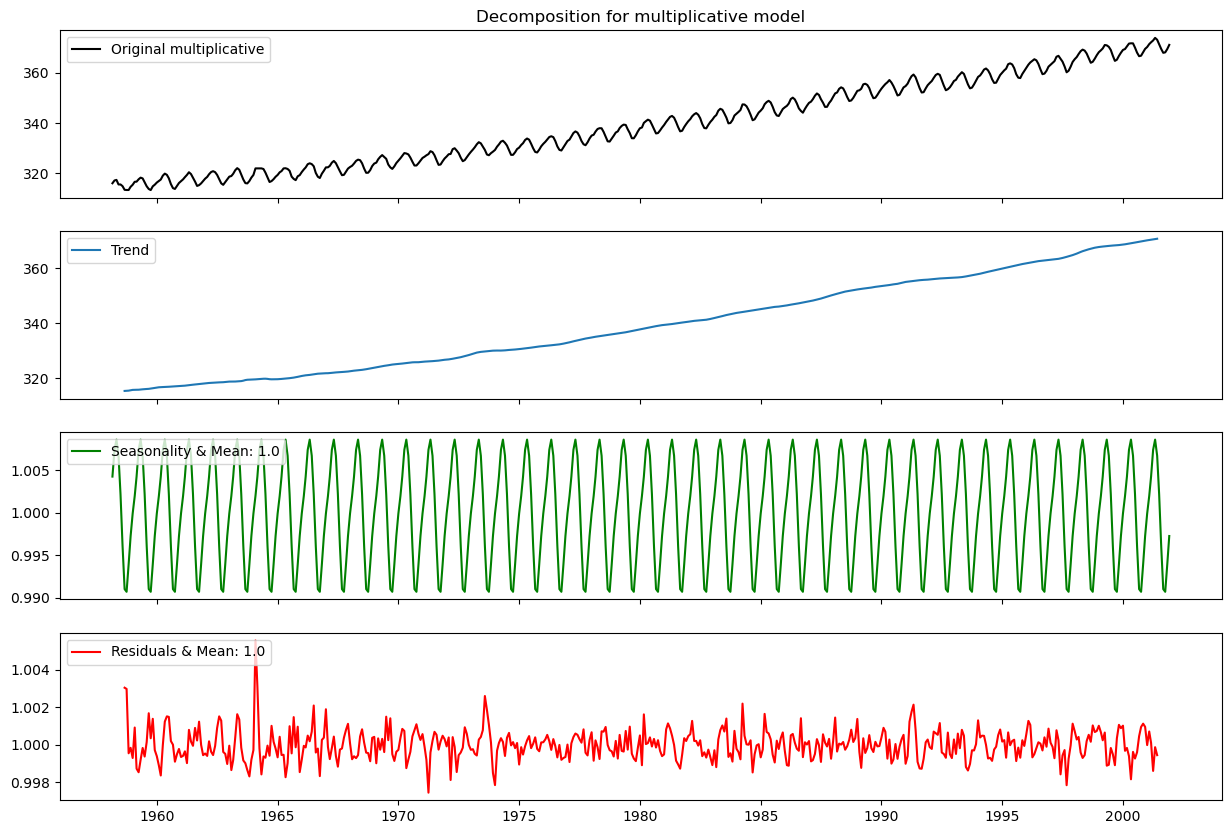

Result: Non-Stationary (H0: non-stationary, p-value: 0.999)


In [110]:
def ts_decompose(y, model="additive", stationary=False):
    result = seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

    if stationary:
        is_stationary(y)
        
for model in ["additive", "multiplicative"]:
    ts_decompose(y, model, stationary=True)

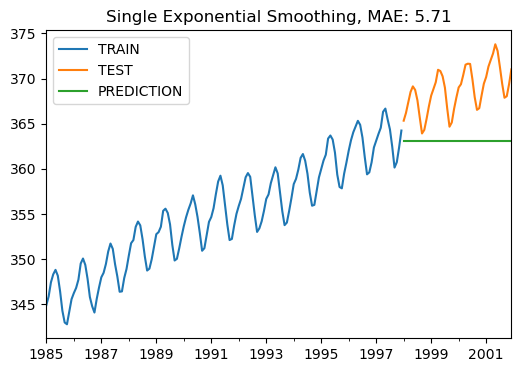

In [113]:
def plot_co2(train, test, y_pred, title):
    mae = mean_absolute_error(test, y_pred)
    train["1985":].plot(legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae,2)}")
    test.plot(legend=True, label="TEST", figsize=(6, 4))
    y_pred.plot(legend=True, label="PREDICTION")
    plt.show()

# Autocorrelation (ACF)

Informally, autocorrelation is the similarity between observations as a function of the time lag between them.

![image.png](https://miro.medium.com/max/700/1*F5wTJgw8dpteJssJVGXPcg.png)

Above is an example of an autocorrelation plot. Looking closely, you realize that the first value and the 24th value have a high autocorrelation. Similarly, the 12th and 36th observations are highly correlated. This means that we will find a very similar value at every 24 unit of time.
Notice how the plot looks like sinusoidal function. This is a hint for seasonality, and you can find its value by finding the period in the plot above, which would give 24h.

Variance is : $Var(x_t)= \sigma^2_w(1+\theta^2_1)$

Autocorrelation function (ACF) is: $ \rho_1 = \dfrac{\theta_1}{1+\theta^2_1}, \text{ and } \rho_h = 0 \text{ for } h \ge 2 $

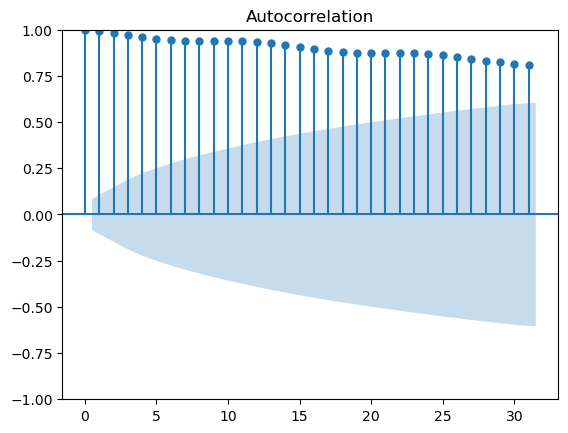

In [122]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(y, lags=31)
pyplot.show()

# 1) AR(p): Autoregression

This is basically a regression of the time series onto itself. Here, we assume that the current value depends on its previous values with some lag. It takes a parameter p which represents the maximum lag. To find it, we look at the partial autocorrelation plot and identify the lag after which most lags are not significant.

In an autoregression model, we forecast the variable of interest using a linear combination of past values of the variable.

Thus, an autoregressive model of order p can be written as;

>$y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}, $

where $\varepsilon_t$ s white noise. This is like a multiple regression but with lagged values of yt as predictors.


> Estimation is made by a linear combination of observations from previous time steps.

> Suitable for univariate time series without trend and seasonality

# 2) MA(q): Moving Average

A moving average term in a time series model is a past error (multiplied by a coefficient).

>The 1st order moving average model, denoted by MA(1) is:

> $x_t = \mu + w_t +\theta_1w_{t-1}$

>The 2nd order moving average model, denoted by MA(2) is:

> $x_t = \mu + w_t +\theta_1w_{t-1}+\theta_2w_{t-2}$

>The qth order moving average model, denoted by MA(q) is:

> $x_t = \mu + w_t +\theta_1w_{t-1}+\theta_2w_{t-2}+\dots + \theta_qw_{t-q}$


## ACF for General MA(q) Models

A property of MA(q) models in general is that there are nonzero autocorrelations for the first q lags and autocorrelations = 0 for all lags > q.

For a time series;

> $\rho_h = \dfrac{\text{Covariance for lag h}}{\text{Variance}}$

Apply this result to get the ACF

## Partial Autocorrelation Function (PACF)

In general, a partial correlation is a conditional correlation. It is the correlation between two variables under the assumption that we know and take into account the values of some other set of variables. For instance, consider a regression context in which y is the response variable and x1, x2 and x3 are predictor variables. The partial correlation between y and x3 is the correlation between the variables determined taking into account how both y and x3 are related to x1 and x2.

In regression, this partial correlation could be found by correlating the residuals from two different regressions:

>Regression in which we predict y from x1 and x2

>regression in which we predict x3 from x1 and x2, Basically we correlate the parts of y and x3 that are not predicted by x1 and x2


$\dfrac{\text{Covariance}(y, x_3|x_1, x_2)}{\sqrt{\text{Variance}(y|x_1, x_2)\text{Variance}(x_3| x_1, x_2)}}$

# Some Useful Facts About PACF and ACF Patterns

__Identification of an AR model is often best done with the PACF.__

> For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.

__Identification of an MA model is often best done with the ACF rather than the PACF__

>For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.

# ARMA Model(p,q) = AR(p) + MA(q)

ARIMA models, also called Box-Jenkins models, are models that may possibly include autoregressive terms, moving average terms, and differencing operations. Various abbreviations are used:

>When a model only involves autoregressive terms it may be referred to as an AR model. When a model only involves moving average terms, it may be referred to as an MA model.

>When no differencing is involved, the abbreviation ARMA may be used.

__Summary:__

>AutoRegressive Moving Average(ARIMA) combines AR and MA methods

>It predicts with a linear combination of past values ​​and past errors.

> Suitable for univariate time series without trend and seasonality

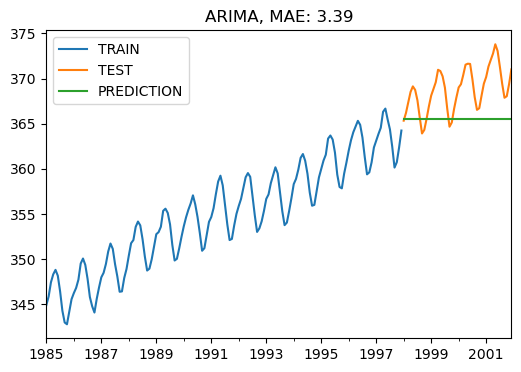

1958-03-01      0.000000
1958-04-01    316.100323
1958-05-01    317.989142
1958-06-01    317.393152
1958-07-01    314.022680
                 ...    
1997-08-01    363.727702
1997-09-01    360.958123
1997-10-01    358.575128
1997-11-01    361.804340
1997-12-01    363.493056
Freq: MS, Name: predicted_mean, Length: 478, dtype: float64

In [123]:
##################################################
# ARIMA(p, d, q): (Autoregressive Integrated Moving Average)
##################################################


arima_model = ARIMA(train, order=(1, 1, 1)).fit()
arima_model.summary()

y_pred = arima_model.forecast(48)[0]
y_pred = pd.Series(y_pred, index=test.index)


plot_co2(train, test, y_pred, "ARIMA")

arima_model.predict(dynamic=False)

In [124]:
############################
# Hyperparameter Optimization (Model Derecelerini Belirleme)
############################

#1. Determining Model Grade Based on AIC Statistics
#2. Determining Model Grade Based on ACF & PACF Charts

############################
# Determining Model Grade Based on AIC & BIC Statistics
############################

# producing p and q combinations
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))

def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arma_model_result = ARIMA(train, order).fit(disp=0)
            aic = arma_model_result.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
            print('ARIMA%s AIC=%.2f' % (order, aic))
        except:
            continue
    print('Best ARIMA%s AIC=%.2f' % (best_params, best_aic))
    return best_params


best_params_aic = arima_optimizer_aic(train, pdq)


Best ARIMANone AIC=inf


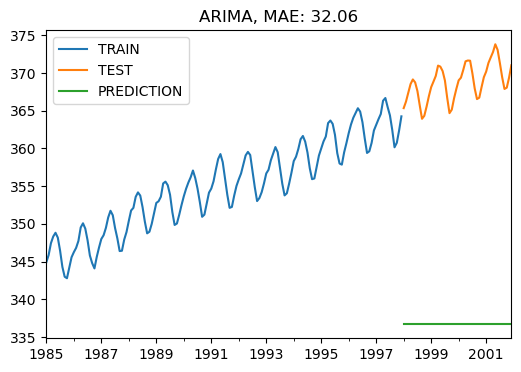

In [125]:
############################
# Final Model
############################

arima_model = ARIMA(train, best_params_aic).fit()
y_pred = arima_model.forecast(48)[0]
y_pred = pd.Series(y_pred, index=test.index)

plot_co2(train, test, y_pred, "ARIMA")

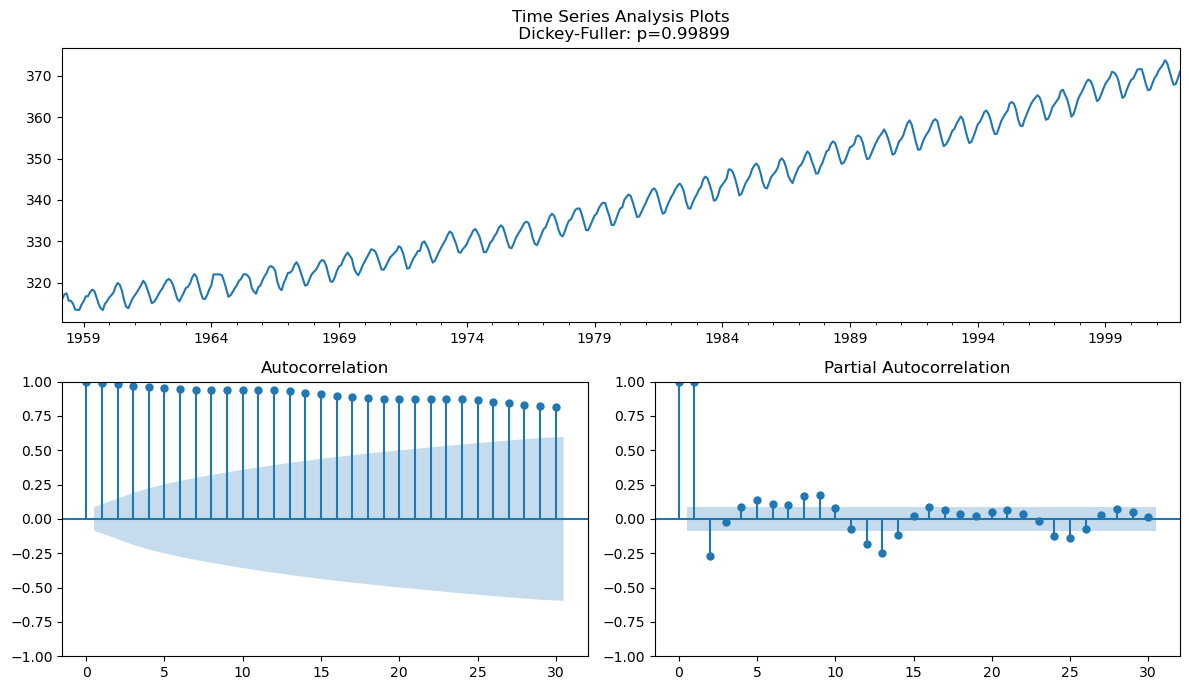

In [126]:
############################
# Determining Model Grade Based on ACF & PACF Charts
############################

def acf_pacf(y, lags=30):
    plt.figure(figsize=(12, 7))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    y.plot(ax=ts_ax)

    # Stationarity test (HO: Series is not Stationary. H1: Series is Stationary.)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()
    plt.show()

acf_pacf(y)

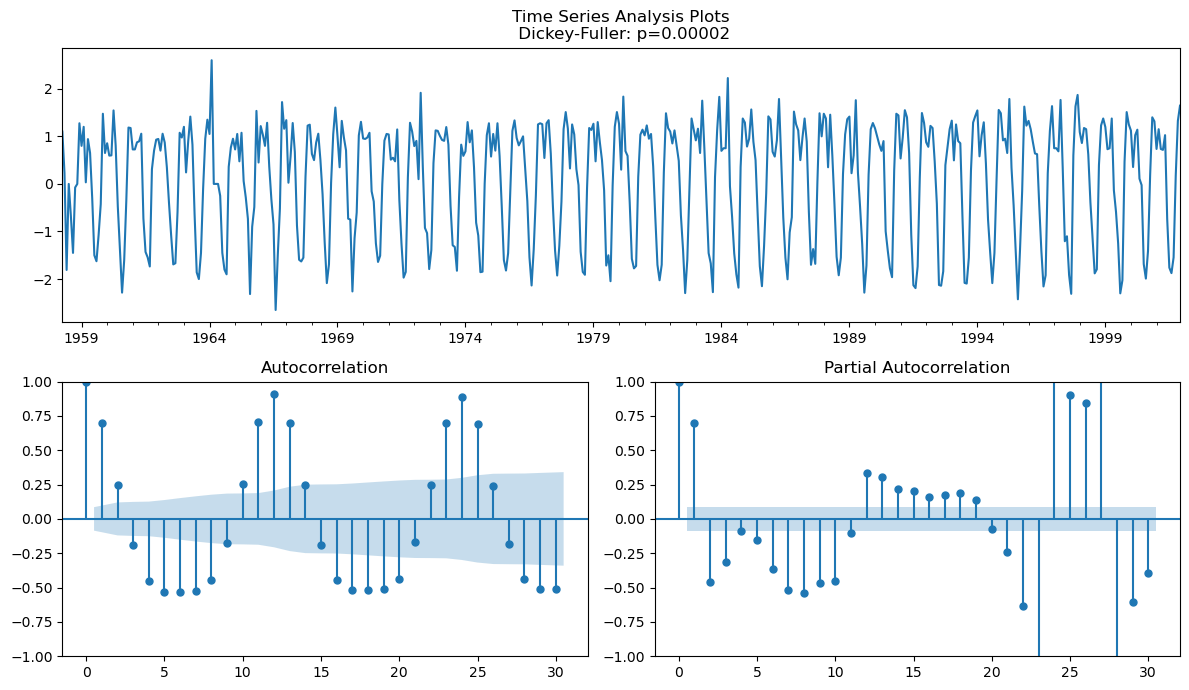

In [127]:
######################
# Determining Model Grade with ACF and PACF Chart
######################


# IF ACF width "DECREASE" relative to the delays and PACF "CUT" after the p delay means it's an AR(p) pattern.

# If the ACF width q "CUT" after the delay and the PACF width "DECREASE" according to the delays, it means it's a MA(q) pattern.

# If the widths of ACF and PACF are decreasing according to the delays, it means it is an ARMA model.
df_diff = y.diff()
df_diff.dropna(inplace=True)

acf_pacf(df_diff)

# SARIMA(p, d, q): (Seasonal Autoregressive Integrated Moving-Average)

After, we add the order of integration I(d). The parameter d represents the number of differences required to make the series stationary.
Finally, we add the final component: seasonality S(P, D, Q, s), where s is simply the season’s length. Furthermore, this component requires the parameters P and Q which are the same as p and q, but for the seasonal component. Finally, D is the order of seasonal integration representing the number of differences required to remove seasonality from the series.
Combining all, we get the SARIMA(p, d, q)(P, D, Q, s) model.
The main takeaway is: before modelling with SARIMA, we must apply transformations to our time series to remove seasonality and any non-stationary behaviors.


__Summary__:

>ARIMA + seasonality

>It can be used in univariate series with trend and/or seasonality.

>The p,d,q parameters are the parameters from the ARIMA model. They are trend elements and ARIMA can model the trend.

>p: Actual value delay number (autoregressive degree)

>d: Number of difference operations (degree of difference)

>q: Error delay number (Moving average degree)

P,D,Q seasonal lag numbers.

m is the number of time steps for a single seasonal period. Expresses the structure of seasonality.

# Model Usage for Different Scenario

>Stationarity: SES, AR, MA, ARMA

>Trend : DES, ARIMA, SARIMA

>Trend + Seasonality: TES + SARIMA

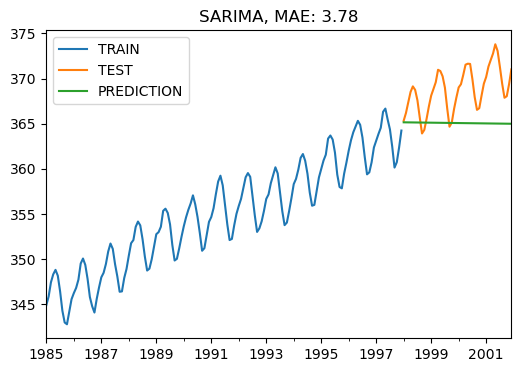

In [128]:
##################################################
# SARIMA(p, d, q): (Seasonal Autoregressive Integrated Moving-Average)
##################################################



model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(0, 0, 0, 12))
sarima_model = model.fit(disp=0)

y_pred_test = sarima_model.get_forecast(steps=48)
y_pred = y_pred_test.predicted_mean
y_pred = pd.Series(y_pred, index=test.index)

plot_co2(train, test, y_pred, "SARIMA")

In [129]:
############################
# Hyperparameter Optimization
############################


p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), float("inf"), None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                results = sarimax_model.fit(disp=0)
                aic = results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
                print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, aic))
            except:
                continue
    print('SARIMA{}x{}12 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    return best_order, best_seasonal_order


best_order, best_seasonal_order = sarima_optimizer_aic(train, pdq, seasonal_pdq)



SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:6922.606550808509
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6318.305219680773
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1643.9996657880365
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1428.2938925355716
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1900.7135451065974
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1618.571058165843
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1205.0254009703658
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:973.2077276804098
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6269.190364736156
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:5663.567928017055
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1229.8447515611213
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1126.5843176947542
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1499.953488383509
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:6254.3198725450075
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1008.1602685174421
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:767.6332872741389
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1523.9134546906607
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1

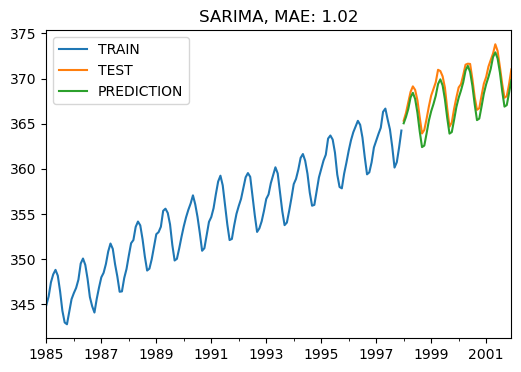

In [130]:
############################
# Final Model
############################

model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)

y_pred_test = sarima_final_model.get_forecast(steps=48)

# MAE
y_pred = y_pred_test.predicted_mean
y_pred = pd.Series(y_pred, index=test.index)

plot_co2(train, test, y_pred, "SARIMA")

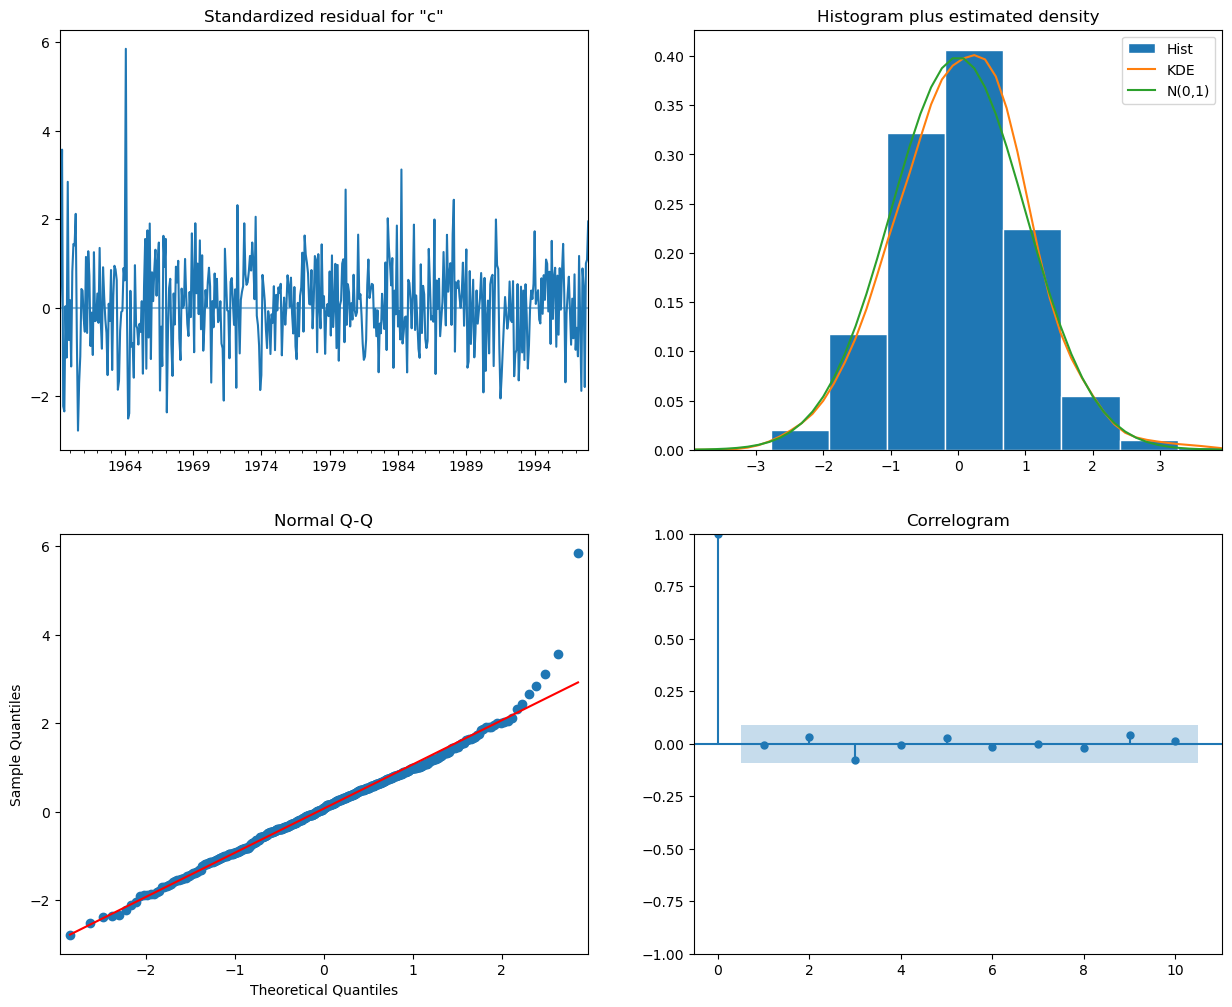

In [131]:
##################################################
# Examining the Statistical Outputs of the Model
##################################################
sarima_final_model.plot_diagnostics(figsize=(15, 12))
plt.show()

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - MAE:368.7634375
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - MAE:324.1790915674042
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - MAE:5.063020833333329
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - MAE:4.80332436976764
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - MAE:5.150801203511125
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - MAE:4.839717716951221
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - MAE:3.3237250934317117
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - MAE:1.5279753051613056
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - MAE:364.9178691427697
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - MAE:320.4050599100865
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - MAE:4.985339483492982
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - MAE:4.765306215961874
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - MAE:4.990436440757389
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - MAE:350.8231031865059
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - MAE:3.6741534595663325
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - MAE:1.5667231526186758
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - MAE:4.526979166666664
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - MAE:3.93154014463

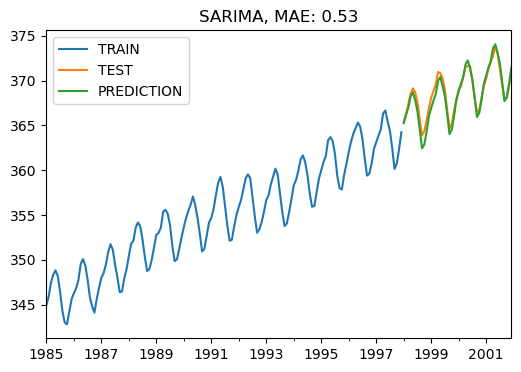

In [132]:
##################################################
# BONUS: SARIMA Optimization for MAE
##################################################

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

def sarima_optimizer_mae(train, pdq, seasonal_pdq):
    best_mae, best_order, best_seasonal_order = float("inf"), float("inf"), None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                sarima_model = model.fit(disp=0)
                y_pred_test = sarima_model.get_forecast(steps=48)
                y_pred = y_pred_test.predicted_mean
                mae = mean_absolute_error(test, y_pred)

                # mae = fit_model_sarima(train, val, param, param_seasonal)

                if mae < best_mae:
                    best_mae, best_order, best_seasonal_order = mae, param, param_seasonal
                print('SARIMA{}x{}12 - MAE:{}'.format(param, param_seasonal, mae))
            except:
                continue
    print('SARIMA{}x{}12 - MAE:{}'.format(best_order, best_seasonal_order, best_mae))
    return best_order, best_seasonal_order

best_order, best_seasonal_order = sarima_optimizer_mae(train, pdq, seasonal_pdq)

model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)

y_pred_test = sarima_final_model.get_forecast(steps=48)
y_pred = y_pred_test.predicted_mean
y_pred = pd.Series(y_pred, index=test.index)


plot_co2(train, test, y_pred, "SARIMA")